# Match DMRs to featureCounts matrix

In [1]:
# import DMR dataframes from txt file 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read in DMR data
dmrNA = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/NvsA_gene_ids.txt', sep='\t', header=None)
dmrNR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/NvsR_gene_ids.txt', sep='\t', header=None)
dmrAR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/AvsR_gene_ids.txt', sep='\t', header=None)

In [2]:
# import fetaure cpounts (gene expression data)
expression = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/9_create_GeneCountsMatrix/gene_matrix_count.csv', sep=',', index_col=0)

In [3]:
# convert df to list for all DMR dataframes
dmrna = dmrNA[0].to_list()
dmrnr = dmrNR[0].to_list()
dmrar = dmrAR[0].to_list()

In [4]:
# filter the expression data for the DMRs
expressionNA = expression[expression.index.isin(dmrna)]
expressionNR = expression[expression.index.isin(dmrnr)]
expressionAR = expression[expression.index.isin(dmrar)]

# Filter out low expression 


In [5]:
# filter the rows that have as a sum less than 50 counts
expressionNA = expressionNA[(expressionNA.sum(axis=1) >= 50)]
expressionNR = expressionNR[(expressionNR.sum(axis=1) >= 50)]
expressionAR = expressionAR[(expressionAR.sum(axis=1) >= 50)]

In [6]:
# reorder the columns of the expression dataframes
# Specify the desired column order
column_order = ['N1', 'N2', 'N3', 'N7', 'A1', 'A2', 'A4', 'A7', 'R2', 'R3', 'R7', 'R8']

# Reorder the dataframe columns
expressionNA = expressionNA.reindex(columns=column_order)
expressionNR = expressionNR.reindex(columns=column_order)
expressionAR = expressionAR.reindex(columns=column_order)



# PLOT

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl

In [10]:
# Normoxia vs Anoxia 
row_labelNA = expressionNA.index.to_numpy()
col_labelNA = expressionNA.columns.to_numpy()
dataNA = expressionNA.to_numpy()

# Normoxia vs Reoxygenation
row_labelNR = expressionNR.index.to_numpy()
col_labelNR = expressionNR.columns.to_numpy()
dataNR = expressionNR.to_numpy()

# Anoxia vs Reoxygenation 
row_labelAR = expressionAR.index.to_numpy()
col_labelAR = expressionAR.columns.to_numpy()
dataAR = expressionAR.to_numpy()

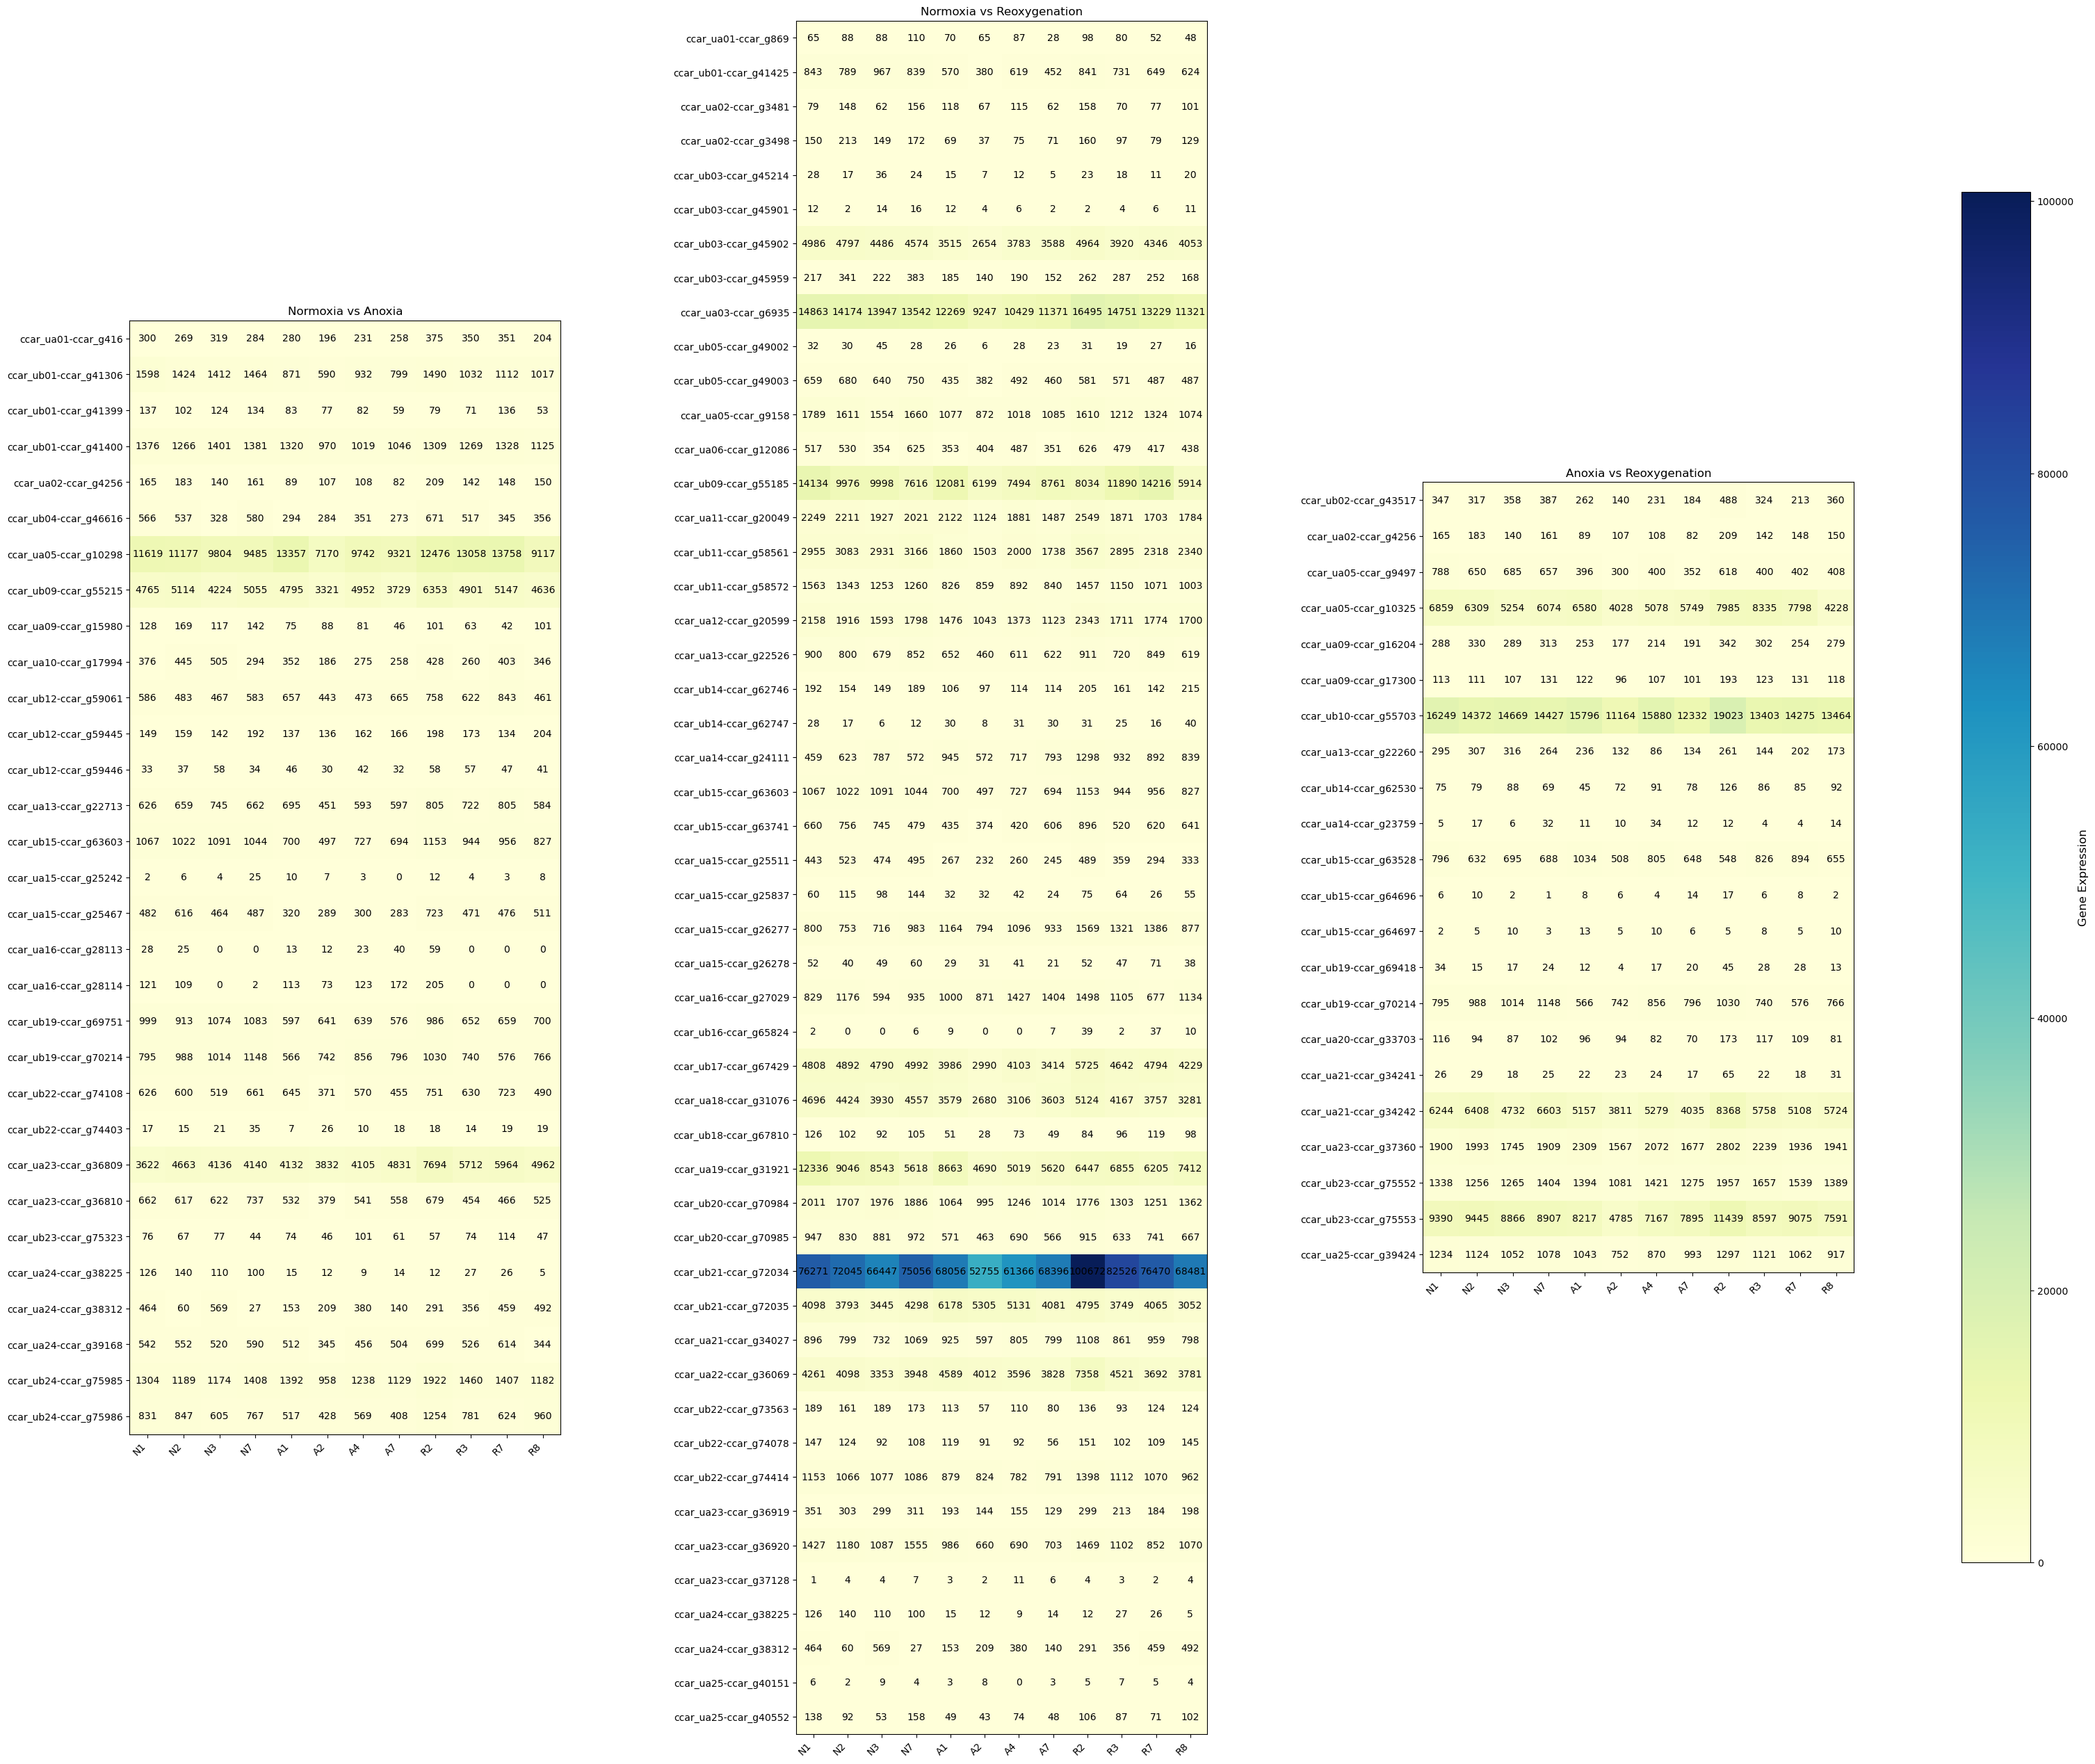

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(40, 32), gridspec_kw={'wspace': 0.5})

# Find the overall min and max values from all data arrays
overall_min = min(dataNA.min(), dataNR.min(), dataAR.min())
overall_max = max(dataNA.max(), dataNR.max(), dataAR.max())

# Plot the heatmaps with adjusted scale
plot_titles = ["Normoxia vs Anoxia", "Normoxia vs Reoxygenation", "Anoxia vs Reoxygenation"]
for i, data in enumerate([dataNA, dataNR, dataAR]):
    row_label, col_label = [row_labelNA, row_labelNR, row_labelAR][i], [col_labelNA, col_labelNR, col_labelAR][i]
    
    im = axs[i].imshow(data, cmap="YlGnBu", vmin=overall_min, vmax=overall_max)

    for r in range(len(row_label)):
        for c in range(len(col_label)):
            axs[i].text(c, r, data[r, c], ha='center', va='center', color='black')

    axs[i].set_title(plot_titles[i])
    axs[i].set_xticks(np.arange(len(col_label)))
    axs[i].set_yticks(np.arange(len(row_label)))
    axs[i].set_xticklabels(col_label)
    axs[i].set_yticklabels(row_label)
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right")

# Create a single colorbar for all subplots using the overall min and max values
cbar = fig.colorbar(im, ax=axs, shrink=0.8, location='right')
cbar.set_label("Gene Expression", fontsize=12)

plt.show()
# save the plot
fig.savefig('8_DMR_gene_expression/DMR_gene_expression_heatmap.png')
# save as pdf 
fig.savefig('8_DMR_gene_expression/DMR_gene_expression_heatmap.pdf')
